The percentage RMSE score is:  0.5794471794014293
The MAPE score is:  -0.30974408946483584
The MBE score is:  -0.0022525687173657097


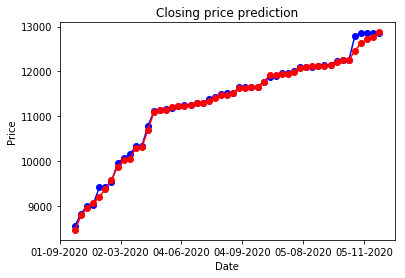

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, depth=10, min_leaf=5):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        #print(self.n_features, "sha: ",x.shape[1])    
        self.x, self.y, self.sample_sz, self.depth, self.min_leaf  = x, y, sample_sz, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        #print(self.x, self.y)
        return DecisionTree(self.x[idxs], self.y[idxs], self.n_features, f_idxs,
                    idxs=np.array(range(self.sample_sz)),depth = self.depth, min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs,idxs,depth=10, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
#         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth-1, min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth-1, min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf') or self.depth <= 0 
    

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)
        
        

dataset = pd.read_csv('dataset.csv', usecols=['Date', 'Open', 'Close', 'High', 'Low', 'Adj Close'])
no_of_records = len(dataset.index)
temp_close_list = dataset['Close']
temp_close_list = temp_close_list.shift(periods=-1, fill_value=15000)
dataset['Next_Close'] = [temp_close_list[i] for i in range(len(temp_close_list))]
dataset = dataset.sample(frac=1)
dates = dataset.iloc[:, 0].values
x = dataset.iloc[:, 1:-2].values
y = dataset.iloc[:, -2].values

#Normalization of Features i.e. Open High and Low values
for i in range(len(x)):
    for j in range(len(x[i])):
        x[i][j] = x[i][j] / 15000
#Normalization of predicted Closing Stock
for i in range(len(y)):
    y[i] = y[i] / 15000

x_train, y_train, x_test, y_test = x[:200], y[:200], x[200:], y[200:]
rf = RandomForest(x_train, y_train, 10, 'log2', 200)

y_res = rf.predict(x_test)
#calculating the RootMeanSquareError, MeanAbsolutePercentageError, MeanBiasError
rmse_score = 0
mape_score = 0
mbe_score = 0
for i in range(len(y_test)):
    rmse_score = rmse_score + ((y_test[i]-y_res[i])**2)
    mape_score = mape_score + ((y_test[i]-y_res[i])/y_test[i])
    mbe_score = mbe_score + (y_test[i]-y_res[i])
mape_score = mape_score/len(y_test)*100
mbe_score = mbe_score/len(y_test)
rmse_score = math.sqrt(rmse_score/len(y_test))
rmse_score_percentage = rmse_score*100
print("The percentage RMSE score is: ", rmse_score_percentage)
print("The MAPE score is: ", mape_score)
print("The MBE score is: ", mbe_score)

plot_x = dates[200:]
plot_x.sort()
plot_orig_y, plot_pred_y = [], []
y_res.sort()
y_test.sort()
for i in y_res:
    plot_pred_y.append(i*15000)
for i in y_test:
    plot_orig_y.append(i*15000)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title('Closing price prediction')
plt.plot(plot_x, plot_pred_y, marker='o', color="blue")
plt.plot(plot_x, plot_orig_y, marker='o', color="red")
ax = plt.gca()
start, end = ax.get_xlim()
stepsize = 10
ax.xaxis.set_ticks(np.arange(start, end, stepsize))
plt.show()
